# Benchmarking doubelt detection methods with Demuxlet data sets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dat_dir = "../data/"
os.chdir(dat_dir)

### Load data

#### Demuxlet

In [2]:
demux_ctrl = pd.read_csv(dat_dir + "/demux_ctrl/demux_table.tsv.gz", sep = "\t")
demux_stim = pd.read_csv(dat_dir + "/demux_stim/demux_table.tsv.gz", sep = "\t")

demux_ctrl['doublet'] = demux_ctrl['multiplets'] == 'doublet'
demux_stim['doublet'] = demux_stim['multiplets'] == 'doublet'

In [3]:
demux_ctrl[:5]

,cellID,tsne1,tsne2,ind,stim,cluster,cell,multiplets,doublet
0,AAACATACAATGCC-1,-4.277833,-19.294709,107,ctrl,5,CD4 T cells,doublet,True
1,AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet,False
2,AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet,False
3,AAACATACCAGCTA-1,-28.132584,24.925484,1256,ctrl,9,CD14+ Monocytes,doublet,True
4,AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet,False


#### DoubletFinder

In [4]:
dbfinder_ctrl = pd.read_csv(dat_dir + "/demux_ctrl/doubletFinder_table.tsv", header=0, sep="\t")
dbfinder_stim = pd.read_csv(dat_dir + "/demux_stim/doubletFinder_table.tsv", header=0, sep="\t")

dbfinder_stim.cellID = [x + "-1" for x in dbfinder_stim.cellID]
dbfinder_ctrl.cellID = [x + "-1" for x in dbfinder_ctrl.cellID]

dbfinder_ctrl[:5]

,cellID,pANN_fix,label_fix,pANN_sweep,label_sweep
0,AAACATACAATGCC-1,0.9516,Doublet,0.6316,Doublet
1,AAACATACATTTCC-1,0.5968,Singlet,0.1579,Singlet
2,AAACATACCAGAAA-1,0.4677,Singlet,0.1053,Singlet
3,AAACATACCAGCTA-1,0.8710,Doublet,0.4211,Doublet
4,AAACATACCATGCA-1,0.5161,Singlet,0.1053,Singlet


In [5]:
print(np.mean(dbfinder_stim.cellID == demux_stim.cellID))
print(np.mean(dbfinder_ctrl.cellID == demux_ctrl.cellID))

print(np.mean(dbfinder_stim.label_fix == "Doublet"))
print(np.mean(dbfinder_ctrl.label_fix == "Doublet"))

1.0
1.0
0.12480963588536619
0.1268896641357138


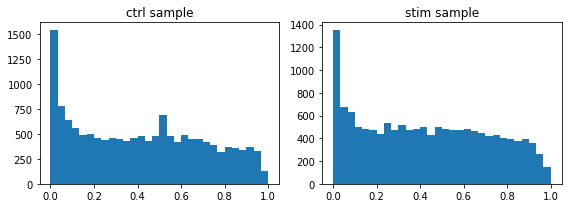

In [6]:
fig = plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.hist(dbfinder_ctrl.pANN_fix, bins=30)
plt.title("ctrl sample")

plt.subplot(1, 2, 2)
plt.hist(dbfinder_stim.pANN_fix, bins=30)
plt.title("stim sample")

plt.tight_layout()
plt.show()

#### scrublet

In [7]:
scrublet_ctrl = pd.read_csv(dat_dir + "/demux_ctrl/scrublet_table.tsv", header=0, sep="\t")
scrublet_stim = pd.read_csv(dat_dir + "/demux_stim/scrublet_table.tsv", header=0, sep="\t")

scrublet_stim[:5]

,cellID,score,label_raw,label_frac
0,AAACATACCAAGCT-1,0.093,False,False
1,AAACATACCCCTAC-1,0.121,False,False
2,AAACATACCCGTAA-1,0.249,False,False
3,AAACATACCCTCGT-1,0.073,False,False
4,AAACATACGAGGTG-1,0.317,True,True


In [8]:
print(np.mean(scrublet_ctrl.cellID == demux_ctrl.cellID))
print(np.mean(scrublet_stim.cellID == demux_stim.cellID))

print(np.mean(scrublet_ctrl['label_frac']))
print(np.mean(scrublet_stim['label_frac']))

1.0
1.0
0.12497434845064642
0.12349439291153261


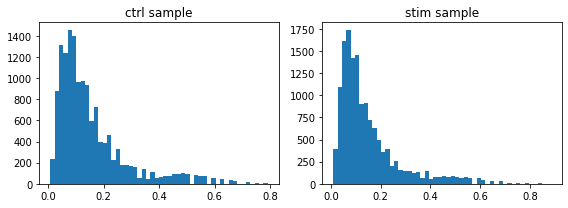

In [9]:
fig = plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.hist(scrublet_ctrl.score, bins=50)
plt.title("ctrl sample")

plt.subplot(1, 2, 2)
plt.hist(scrublet_stim.score, bins=50)
plt.title("stim sample")

plt.tight_layout()
plt.show()

## Comparison

In [10]:
def average_score(x1, x2, x3, 
                  W=np.array([0.25, 0.25, 0.5])):
    """
    """
    X = np.zeros((len(x1), 3))
    X[:, 0] = x1
    X[:, 1] = x2
    X[:, 2] = x3
    
    if W is None:
        W = np.ones((X.shape[1], 1)) / X.shape[1]
    _X = ((X - np.min(X, axis=0, keepdims=True)) /
          (np.max(X, axis=0, keepdims=True) - 
           np.min(X, axis=0, keepdims=True)))

    # _X = ((X - np.mean(X, axis=0, keepdims=True)) /
    #       np.var(X, axis=0, keepdims=True))
    
    return np.dot(_X, W), X

In [11]:
def scatter_with_label(x, y, label1, label2, title="",
                       names=['Singlet', 'SNP only', 'GEX only', 'Both']):
    label1 = np.array(label1)
    label2 = np.array(label2)
    idx0 = (label1 == False) * (label2 == False)
    idx1 = (label1 == True)  * (label2 == False)
    idx2 = (label1 == False) * (label2 == True)
    idx3 = (label1 == True)  * (label2 == True)

    plt.scatter(x[idx0], y[idx0], s=1, label=names[0], color="lightgray")
    plt.scatter(x[idx1], y[idx1], s=1, label="%s: %d" %(names[1], sum(idx1)), color='#4796d7')
    plt.scatter(x[idx2], y[idx2], s=1, label="%s: %d" %(names[2], sum(idx2)), color='#79a702')
    plt.scatter(x[idx3], y[idx3], s=1, label="%s: %d" %(names[3], sum(idx3)), color='#df5858')
    
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("%s: %d cells" %(title, len(x)))
    plt.legend(loc="best", markerscale=5)

In [12]:
def multi_plot(demux_dat, dbfinder_dat, scrublet_dat, 
               _sample, fig_file=None):
    
    fig = plt.figure(figsize=(10, 8), dpi=100)

    ### doubletFinder with pK according to n_cell
    plt.subplot(2, 2, 1)
    scatter_with_label(demux_dat['tsne1'], demux_dat['tsne2'],
                       demux_dat['doublet'], 
                       dbfinder_dat['label_fix'] == 'Doublet',
                       title='dbfinder fix, %s' %(_sample))
    
    ### doubletFinder with sweeped pK
    plt.subplot(2, 2, 2)
    scatter_with_label(demux_dat['tsne1'], demux_dat['tsne2'],
                       demux_dat['doublet'], 
                       dbfinder_dat['label_sweep'] == 'Doublet',
                       title='dbfinder sweep, %s' %(_sample))

    ### scrublet
    plt.subplot(2, 2, 3)
    _doublet_rate = np.mean(dbfinder_dat['label_fix'] == 'Doublet')
    _cut = np.quantile(scrublet_dat['score'], 1 - _doublet_rate)
    scatter_with_label(demux_dat['tsne1'], demux_dat['tsne2'],
                       demux_dat['doublet'], scrublet_dat['score'] >= _cut,
                       title='scrublet, %s' %(_sample))

    ### Combine three values (averaged)
    plt.subplot(2, 2, 4)
    _avg_score, _X = average_score(dbfinder_dat['pANN_fix'], 
                                   dbfinder_dat['pANN_sweep'],
                                   scrublet_dat['score'])
    _doublet_rate = np.mean(dbfinder_dat['label_fix'] == 'Doublet')
    _cut = np.quantile(_avg_score, 1 - _doublet_rate)
    
    scatter_with_label(demux_dat['tsne1'], demux_dat['tsne2'],
                       demux_dat['doublet'], _avg_score > _cut,
                       title='combined-results, %s' %(_sample))
    
    plt.tight_layout()
    if fig_file is not None:
        plt.savefig(fig_file, dpi=200)
    plt.show()

### Stimulated sample

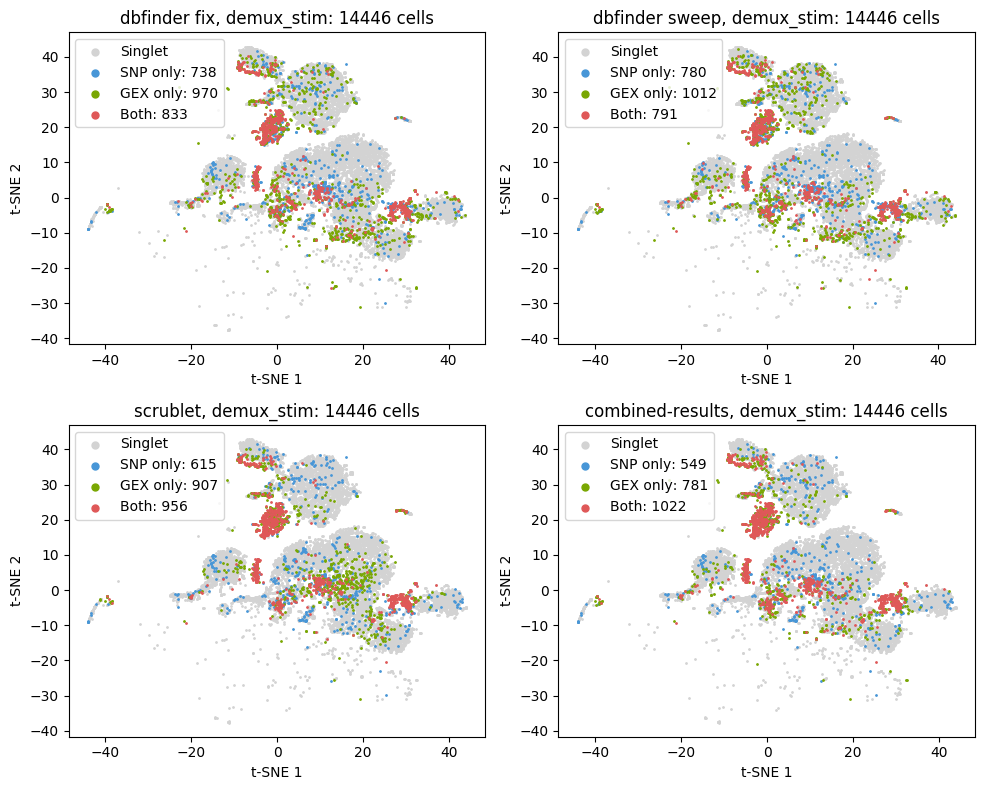

In [13]:
_sample = "demux_stim"
multi_plot(demux_stim, dbfinder_stim, scrublet_stim, _sample, 
           fig_file=dat_dir + "../examples/images/%s.doublet.png" %(_sample))

### Control sample

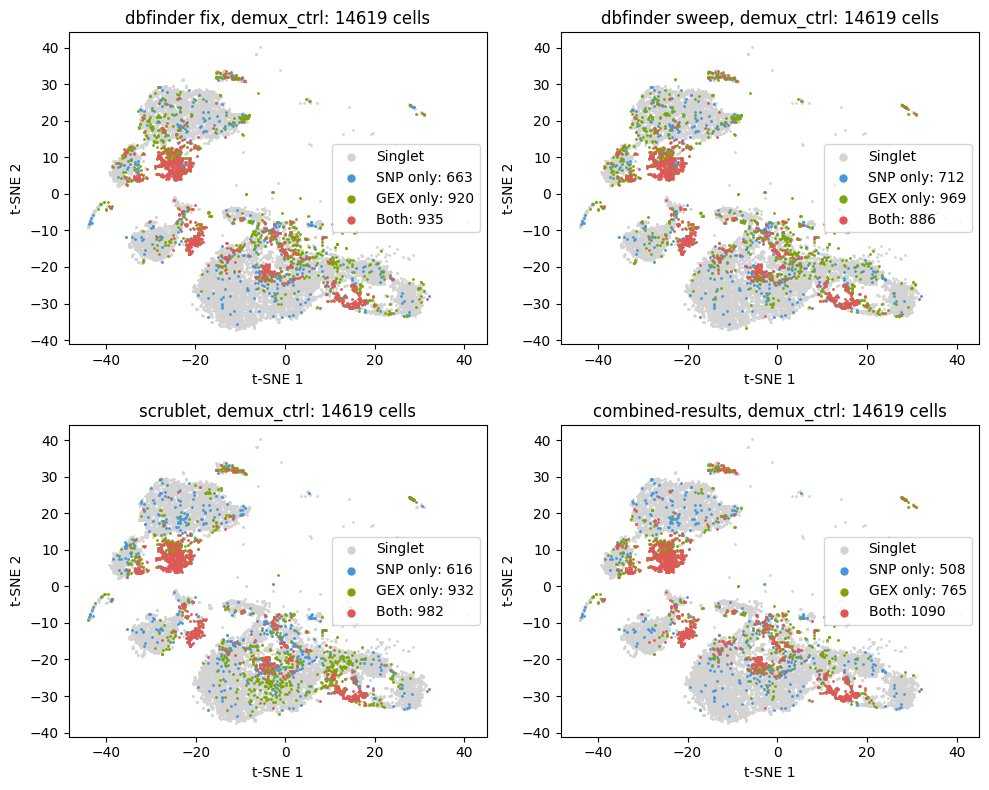

In [14]:
_sample = "demux_ctrl"
multi_plot(demux_ctrl, dbfinder_ctrl, scrublet_ctrl, _sample, 
           fig_file=dat_dir + "../examples/images/%s.doublet.png" %(_sample))

### Using combined file

In [10]:
combined_ctrl = pd.read_csv(dat_dir + "/demux_ctrl/combined_table.tsv", 
                            header=0, sep="\t")

In [11]:
combined_ctrl[:5]

,cellID,dbF_score_fix,dbF_label_fix,dbF_score_sweep,dbF_label_sweep,scb_score,scb_label,combined_score,combined_label
0,AAACATACAATGCC-1,0.952,True,0.632,True,0.320,True,0.595,True
1,AAACATACATTTCC-1,0.597,False,0.158,False,0.128,False,0.265,False
2,AAACATACCAGAAA-1,0.468,False,0.105,False,0.071,False,0.183,False
3,AAACATACCAGCTA-1,0.871,True,0.421,True,0.162,False,0.421,False
4,AAACATACCATGCA-1,0.516,False,0.105,False,0.118,False,0.226,False


In [14]:
np.mean(demux_ctrl['cellID'] == combined_ctrl['cellID'])

1.0

In [18]:
np.unique(demux_ctrl.loc[combined_ctrl['combined_label']]['cell'], 
          return_counts=True)

(array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
        'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes',
        'NK cells'], dtype=object),
 array([145, 606, 441, 294,  55, 197,  16, 101]))

In [22]:
np.unique(list(demux_ctrl['cell']), return_counts=True)

(array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
        'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes',
        'NK cells', 'nan'], dtype='<U17'),
 array([1488, 3365, 6005, 1409,  227,  906,  166, 1051,    2]))

In [41]:
frac_GEX_ctrl=(np.unique(demux_ctrl.loc[combined_ctrl['combined_label']]['cell'], 
           return_counts=True)[1] / 
 np.unique(list(demux_ctrl['cell']), 
           return_counts=True)[1][:8])

In [42]:
frac_SNP_stim=(np.unique(demux_ctrl.loc[demux_ctrl['doublet']]['cell'], 
           return_counts=True)[1] / 
 np.unique(list(demux_ctrl['cell']), 
           return_counts=True)[1][:8])

In [43]:
cell_types = np.unique(demux_stim.loc[combined_stim['combined_label']]['cell'])
for i in range(len(cell_types)):
    print(cell_types[i] + ",%.2f,%.2f" %(frac_GEX_ctrl[i], frac_SNP_stim[i]))

B cells,0.10,0.09
CD14+ Monocytes,0.18,0.14
CD4 T cells,0.07,0.08
CD8 T cells,0.21,0.17
Dendritic cells,0.24,0.09
FCGR3A+ Monocytes,0.22,0.16
Megakaryocytes,0.10,0.08
NK cells,0.10,0.09


### stimulated sample

In [26]:
combined_stim = pd.read_csv(dat_dir + "/demux_stim/combined_table.tsv", 
                            header=0, sep="\t")

In [27]:
np.mean(demux_stim['cellID'] == combined_stim['cellID'])

1.0

In [34]:
frac_GEX_stim = (np.unique(demux_stim.loc[combined_stim['combined_label']]['cell'], 
           return_counts=True)[1] / 
 np.unique(list(demux_stim['cell']), 
           return_counts=True)[1][:8])

In [35]:
frac_SNP_stim = (np.unique(demux_stim.loc[demux_stim['doublet']]['cell'], 
           return_counts=True)[1] / 
 np.unique(list(demux_stim['cell']), 
           return_counts=True)[1][:8])

In [39]:
cell_types = np.unique(demux_stim.loc[combined_stim['combined_label']]['cell'])
for i in range(len(cell_types)):
    print(cell_types[i] + ",%.2f,%.2f" %(frac_GEX_stim[i], frac_SNP_stim[i]))

B cells,0.08,0.07
CD14+ Monocytes,0.18,0.14
CD4 T cells,0.07,0.08
CD8 T cells,0.19,0.17
Dendritic cells,0.21,0.05
FCGR3A+ Monocytes,0.23,0.13
Megakaryocytes,0.07,0.14
NK cells,0.14,0.12


In [40]:
np.unique(demux_stim.loc[combined_stim['combined_label']]['cell']) == np.unique(demux_stim.loc[demux_stim['doublet']]['cell'])

array([ True,  True,  True,  True,  True,  True,  True,  True])